In [1]:
from simulation import Simulation
from maker import SimpleMarketMaker, OrderType
from typing import List, Tuple, Literal

from data_maker import DataMarketMaker, run_mm, run_mm_plus, plot_defaults, plot

import numpy as np

In [2]:
class ExampleDataMarketMaker(DataMarketMaker):
    def update(self, prev_bid_price, prev_ask_price, holding, money, timestamp):
        return prev_bid_price, 0, prev_ask_price, 0, OrderType.new_limit_order(timestamp, timestamp + 100)

In [3]:
data = run_mm_plus(ExampleDataMarketMaker())

Running
Total profit: 0.0
Total holding: 0 at price 100.27218627929688 for a total of 0.0
Total cash: 10000
Final Revenue: 10000.0
Game completed in 0.6847074031829834 seconds


In [31]:
class BadStrategy(DataMarketMaker):
        """
        An example on how to implement a market maker.
        """
        def __init__(self):
            self.prev_bid_history = []
            self.prev_ask_history = []
            
            self.window = 5
            self.simulations = 10
            self.sim_horizon = 3
            
            self.tracker.config_info(["Simulated Price", "Simulated Std"]) # Allow tracker to recognize data points
       
        def update(self, prev_bid_price, prev_ask_price, holding, money, timestamp) -> Tuple[float, int, float, int, OrderType]:
                        
            self.prev_bid_history.append(prev_bid_price)
            self.prev_ask_history.append(prev_ask_price)
            
            mean, std = self.simulate()
            self.tracker.update_info(mean, std) # Keep track of info
            
            buy_dev = std * -0.1
            sell_dev = std * 0.1
            
            max_buy_price = prev_bid_price + buy_dev
            max_sell_price = prev_ask_price + sell_dev
            
            return max_buy_price, int(money/max_buy_price - 1) // 2, max_sell_price, holding//2, OrderType.new_limit_order(timestamp, timestamp + 100)
        
        def simulate(self):    
            price_history = (np.array(self.prev_bid_history[-self.window:]) + np.array(self.prev_ask_history[-self.window:])) / 2
            diffs = np.diff(np.log(price_history[-self.window:]))

            if len(self.prev_bid_history) < self.window:
                avg_orig_price = (self.prev_bid_history[-1] + self.prev_ask_history[-1])/2
                return avg_orig_price, np.std(price_history)
            
            std = np.std(diffs) ** 2
            drift = np.mean(diffs) + std ** 2 / 2

            future_prices = []
            for _ in range(self.simulations): 
                future_prices.append(price_history[-1] * np.exp(np.sum(np.random.normal(drift, std, self.sim_horizon))))

            future_prices = np.array(future_prices)

            return np.mean(future_prices), np.std(future_prices)

In [32]:
strat = BadStrategy()
data = run_mm_plus(strat)

Running
Total profit: -9642.470710754395
Total holding: 1 at price 94.77508544921875 for a total of 94.77508544921875
Total cash: 262.7542037963867
Final Revenue: 357.52928924560547
Game completed in 4.952102184295654 seconds


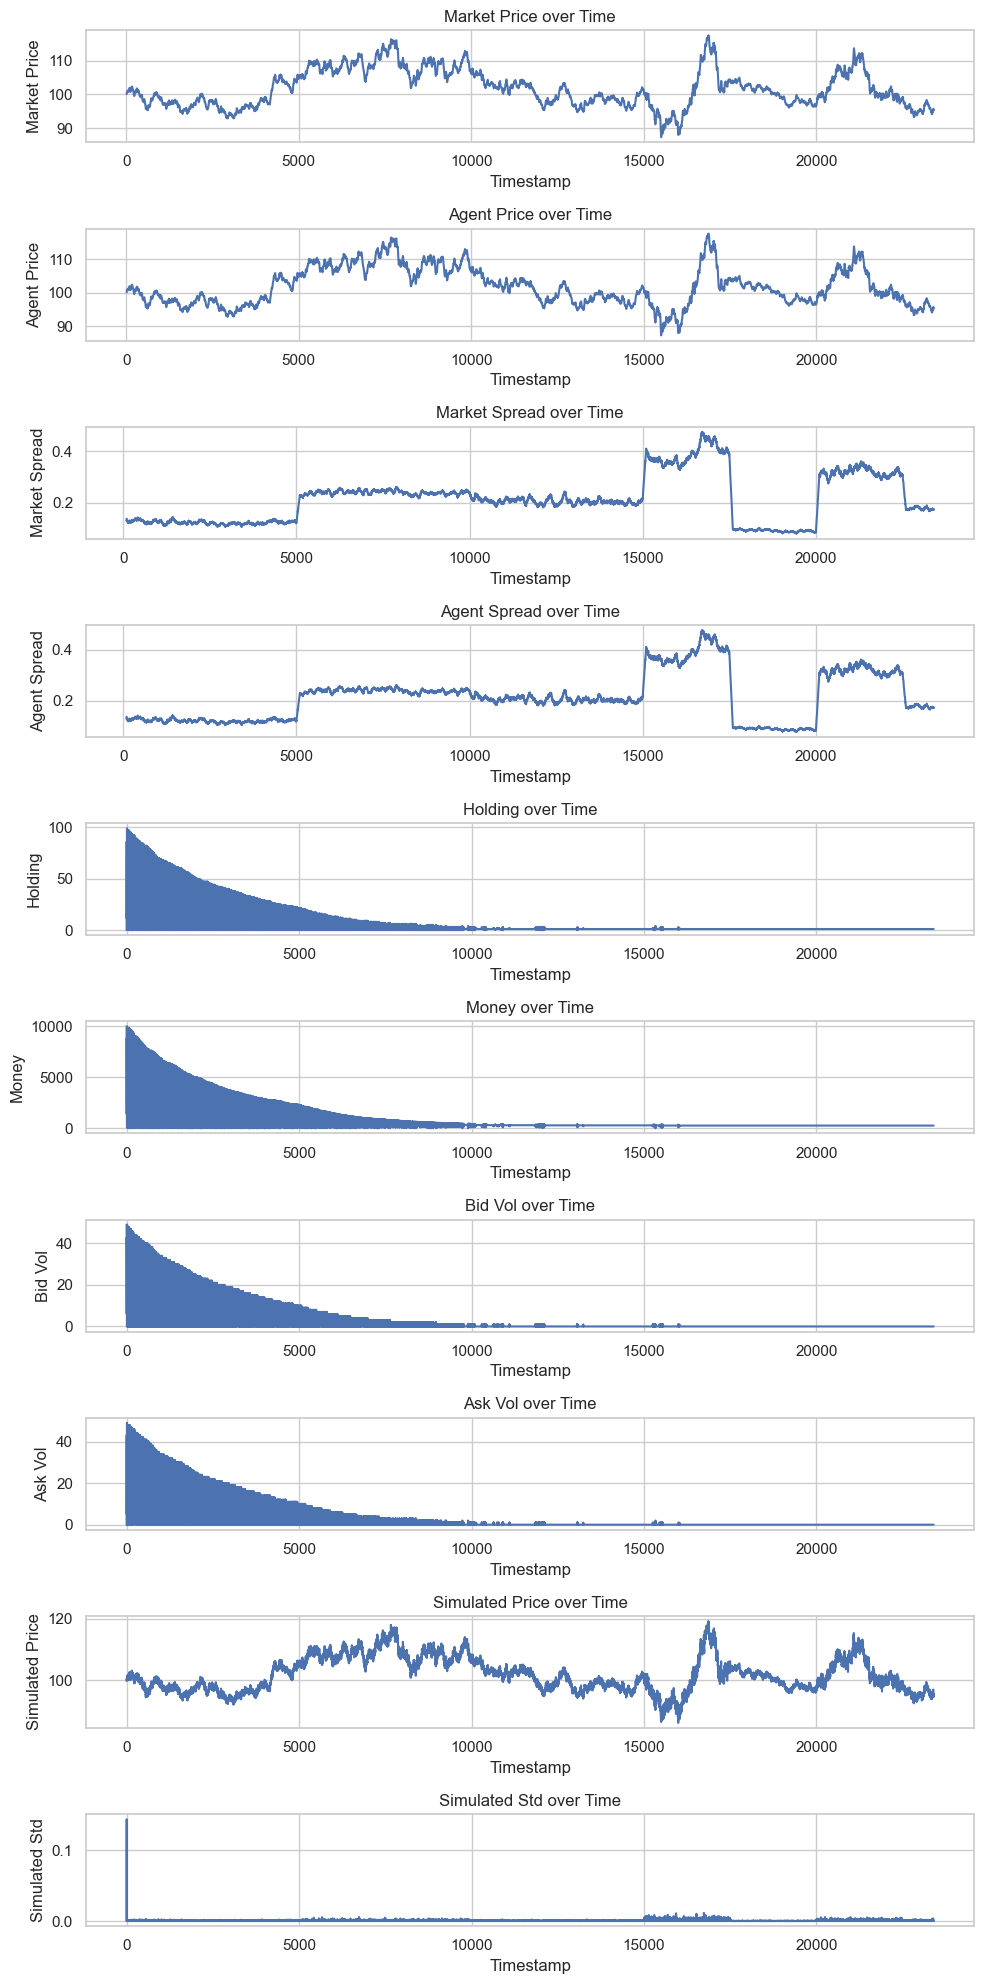

In [33]:
plot_defaults(data, additional_cols = ["Simulated Price", "Simulated Std"])

In [36]:
data["Price"] = (data["Market Bid Price"] + data["Market Ask Price"]) / 2
data

,Market Bid Price,Market Ask Price,Holding,Money,Bid Price,Bid Vol,Ask Price,Ask Vol,Simulated Price,Simulated Std,Price
Timestamp,,,,,,,,,,,
0,99.500000,100.500000,0,10000.000000,99.500000,49,100.500000,0,100.000000,0.000000,100.000000
1,99.924812,100.066811,49,5096.726280,99.924603,25,100.067020,24,99.995811,0.002094,99.995811
2,100.140610,100.220749,74,2591.207558,100.131992,12,100.229367,37,100.180679,0.086177,100.180679
3,100.311073,100.373276,86,1386.728249,100.296713,6,100.387637,43,100.342175,0.143608,100.342175
4,100.028725,100.208939,19,8088.652802,100.028680,39,100.208984,9,100.208087,0.000450,100.118832
...,...,...,...,...,...,...,...,...,...,...,...
23395,95.143204,95.388985,1,262.754204,95.143142,0,95.389046,0,94.962419,0.000614,95.266094
23396,95.133919,95.242439,1,262.754204,95.133882,0,95.242477,0,95.027724,0.000373,95.188179
23397,95.056404,95.254326,1,262.754204,95.056363,0,95.254367,0,95.083493,0.000412,95.155365


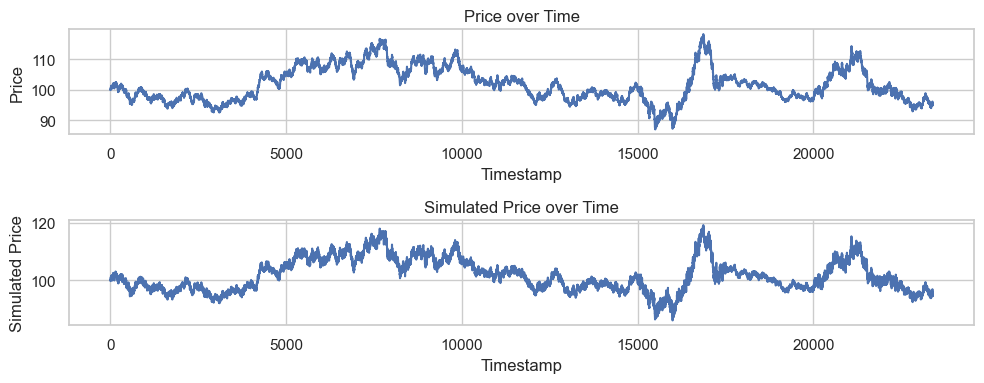

In [37]:
plot(data, ["Price", "Simulated Price"])

In [38]:
price = data["Price"]
sim_price = data["Simulated Price"]

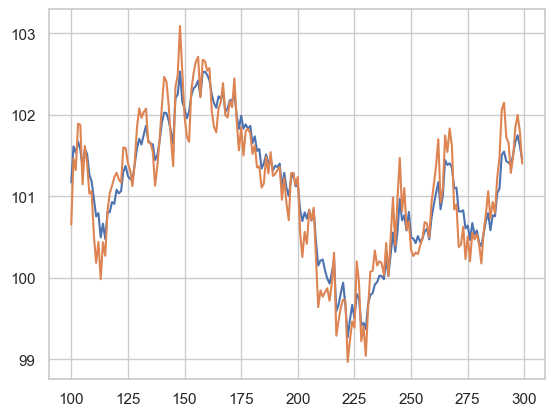

In [41]:
import matplotlib.pyplot as plt
n = 100
x = 200

plt.plot(price[n:n+x])
plt.plot(sim_price[n:n+x])

In [50]:
window = 10
simulations = 1
sim_horizon = 3

def simulate(price_history): 
    diffs = np.diff(np.log(price_history[-window:]))

    std = np.std(diffs) ** 2
    drift = np.mean(diffs) + std ** 2 / 2

    future = []
    for _ in range(simulations): 
        future.append(np.cumsum(np.random.normal(drift, std, sim_horizon)))

    print(future)
        
    future_prices_estimates = price_history[-1] * np.exp(np.sum(np.array(future)))
    
    print(future_prices_estimates)

    return np.mean(future_prices_estimates), np.std(future_prices_estimates)    

In [72]:
window = 10
simulations = 10
sim_horizon = 3

def simulate(price_history):
    diffs = np.diff(np.log(price_history[-window:]))

    std = np.std(diffs) ** 2
    drift = np.mean(diffs) + std ** 2 / 2

    future_prices = []
    for _ in range(simulations): 
        future_prices.append(price_history[-1] * np.exp(np.sum(np.random.normal(drift, std, sim_horizon))))

    future_prices = np.array(future_prices)

    return np.mean(future_prices), np.std(future_prices)
    
simulate(price_history)

(123.96845013378679, 0.013261002619424348)

In [73]:
price_history = np.random.normal(100, 0.5, 20) + np.cumsum(np.random.normal(1, 0.5, 20))
print(price_history)

sims = []
for i in range(2, 20):
    sims.append(simulate(price_history[:i])[0])

[101.47002925 101.81376542 103.37621128 104.80720366 104.81012248
 104.9324695  107.67671021 107.03816628 108.02639648 110.66733967
 111.38425555 112.75392303 112.69755344 113.77086767 115.00252329
 115.07202616 116.27880259 117.62302833 118.86601243 118.34030758]


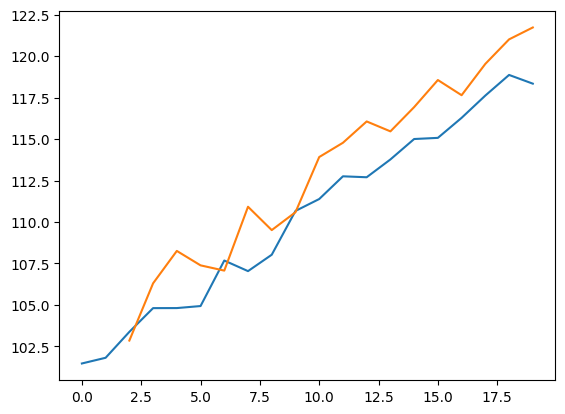

In [76]:
plt.plot(np.arange(20), price_history)
plt.plot(np.arange(2, 20), sims)